In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages
import datetime
from tabulate import tabulate
import plotly.figure_factory as ff
import os
import matplotlib as mpl
import seaborn as sns




#loading the data from spreadsheet
file = "data.xlsx"
raw_df = pd.read_excel(file, names=['Year_of_Booking', 'Week_of_booking', 'Year_of_Departure',
       'Month_of_Departure', 'Week_of_Departure',
       'Weekdays_of_Departure_Group', 'RouteCode', 'SalesSegment',
       'TravelSegment', 'MeasureNames', 'MeasureValues'])



# Formatting the dataframe, pivoting the last column

df = (raw_df.set_index(['Year_of_Booking', 'Week_of_booking', 'Year_of_Departure',
        'Month_of_Departure', 'Week_of_Departure',
        'Weekdays_of_Departure_Group', 'RouteCode', 'SalesSegment',
        'TravelSegment', 'MeasureNames'])['MeasureValues']
          .unstack()
          .reset_index()
          .rename_axis(None, axis=1))


#Check for duplicates in the data
df.duplicated()

#solve possibile duplicates
df.drop_duplicates()

#substitute string W+week into pure integer number
df['Week_of_booking']   = df['Week_of_booking'].map(lambda x: int(x.lstrip('W')))
df['Week_of_Departure'] = df['Week_of_Departure'].map(lambda x: int(x.lstrip('W')))

# remove extra character and white spaces, convert strings into integers for Booked_pass column
for i, elem in enumerate(df['Booked_Pass']): 
    if(type(elem) != int):
        #print(i, elem, type(elem))
        df['Booked_Pass'][i]= int(elem.split()[-1])
        

# replace comma with dot (english format) and convert into float
for i, elem in enumerate(df['Net_Ticket_Revenue']): 
    if(type(elem)== str):      
        df['Net_Ticket_Revenue'][i]= float(elem.replace(u'\xa0', u'').replace(',','.'))
    if(type(elem) == int):
        df['Net_Ticket_Revenue'][i]= float(elem)
#unique sets of values

SaleSegments   = df.SalesSegment.unique()
TravelSegments = df.TravelSegment.unique()
route          = df.RouteCode.unique()
days           = df.Weekdays_of_Departure_Group.unique()
years_book     = df.Year_of_Booking.unique()
years          = df.Year_of_Departure.unique()
weeks          = df.Week_of_Departure.unique()
weeks.sort()
month          = df.Month_of_Departure.unique()[[7,6,0,4,1,3,8,2,10,11,5,9]]


plt.style.use('seaborn')
            

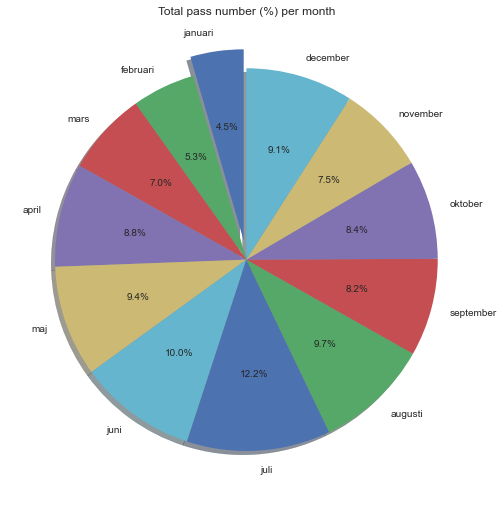

In [69]:
#the month with less pass in absolute       
    
num_pass = np.zeros((month.shape[0]))
for i, m in enumerate(month):
    dum = np.where(df.Month_of_Departure == m)[0]
    num_pass[i] = df.Booked_Pass[dum].sum()

labels = month
explode = np.zeros((month.shape[0])) 
explode[np.where(num_pass == num_pass.min())[0]]=0.1 

fig, ax = plt.subplots(figsize=(8.8, 8.8))
ax.pie(num_pass,explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.set_title('Total pass number (%) per month')
plt.show()

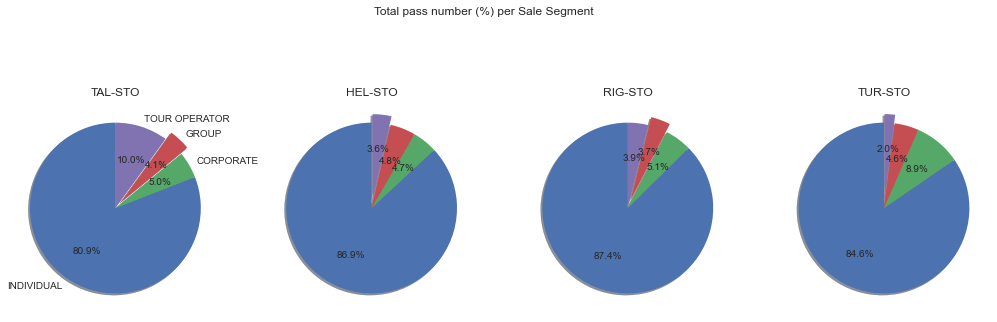

In [70]:
fig, ax = plt.subplots(1,route.shape[0],figsize=(8.8*2, 8.8*2/3.))
fig.suptitle('Total pass number (%) per Sale Segment')
for t, r in enumerate(route):
    num_pass = np.zeros((SaleSegments.shape[0]))
    for i , ss in enumerate(SaleSegments):
        dum = np.where((df.SalesSegment == ss) & (df.RouteCode == r))[0]
        num_pass[i] = df.Booked_Pass[dum].sum()
    labels = SaleSegments
    explode = np.zeros((SaleSegments.shape[0])) 
    explode[np.where(num_pass == num_pass.min())[0]]=0.1 
    if(t!=0):
        ax[t].pie(num_pass,explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90,labeldistance=None)
    else:
        ax[t].pie(num_pass,explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax[t].set_title(route[t])


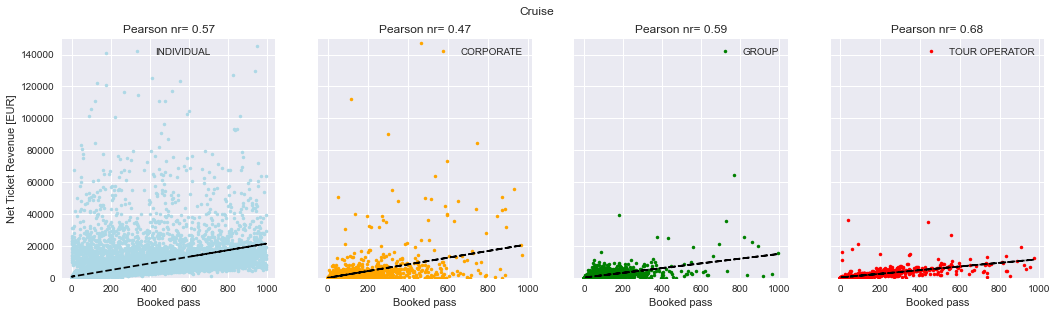

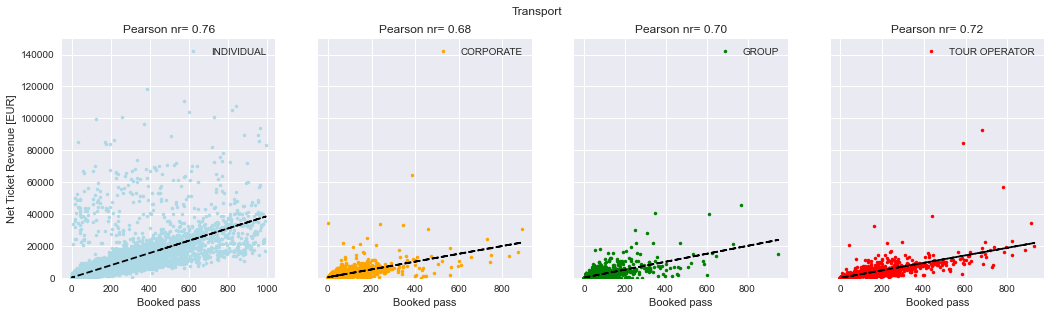

In [71]:
#does more pass  always mean more money?

colors= ['LightBlue', 'Orange', 'Green', 'Red']

for ts in TravelSegments:
    fig, ax = plt.subplots(1,4,figsize=(8.8*2, 8.8/2))
    for i , ss in enumerate(SaleSegments):
        dum = np.where((df.SalesSegment == ss) & (df.TravelSegment == ts))[0]
        x= df.Booked_Pass[dum].to_numpy(dtype=float)
        y= df.Net_Ticket_Revenue[dum].to_numpy(dtype=float)
        Pearson = scs.pearsonr(x, y)[0]
        ax[i].plot(x,y, '.', color= colors[i],label= ss)
        ax[i].set_ylim(0,150000)
        ax[i].set_title('Pearson nr= {:.2f}'.format(Pearson))
        r = np.polyfit(x,y,deg=1)
        ax[i]. plot(x,x*r[0]+r[1], '--k')
        ax[i].set_xlabel('Booked pass')
        if(i !=0):
            plt.setp(ax[i].get_yticklabels(), visible=False)
        else:
            ax[i].set_ylabel('Net Ticket Revenue [EUR]')
        ax[i].legend()
    fig.suptitle(ts)


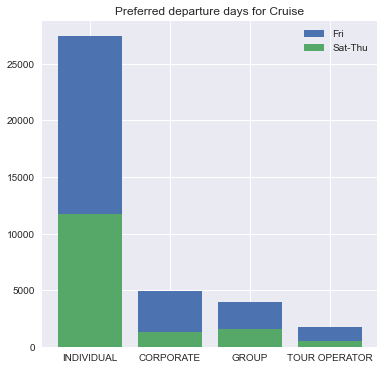

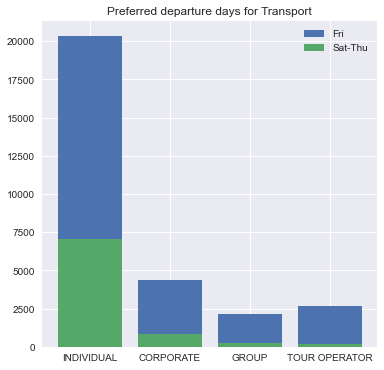

In [72]:
#do people prefer Fri or rest of the week for departures? (for sale segment)
YF = np.zeros(SaleSegments.shape[0])
YS = np.zeros(SaleSegments.shape[0])

for ts in TravelSegments:
    fig, ax = plt.subplots(1,figsize=(6, 6))
    for i , ss in enumerate(SaleSegments):
        dum_F = np.where(((df.SalesSegment == ss)  & (df.Weekdays_of_Departure_Group == days[0])) & (df.TravelSegment == ts))[0]

        dum_S = np.where(((df.SalesSegment == ss)  & (df.Weekdays_of_Departure_Group == days[1])) & (df.TravelSegment == ts))[0]

        YF[i] = df.Weekdays_of_Departure_Group[dum_F].count()
        YS[i] = df.Weekdays_of_Departure_Group[dum_S].count()

    ax.bar(SaleSegments, YF, bottom= YS, tick_label=SaleSegments, label=days[1])
    ax.bar(SaleSegments, YS, tick_label=SaleSegments, label=days[0])
    ax.legend()
    ax.set_title('Preferred departure days for '+ts)

In [73]:
stats = np.zeros((SaleSegments.shape[0],5))
for i , ss in enumerate(SaleSegments):
        dum = np.where(df.SalesSegment == ss)[0]
        diff = np.zeros(dum.shape[0])
        for j, d in enumerate(dum):
            d_Dep = str(df.Year_of_Departure[d])+"-"+str(df.Week_of_Departure[d])
            d_boo = str(df.Year_of_Booking[d])+"-"+str(df.Week_of_booking[d])
            r_Dep = datetime.datetime.strptime(d_Dep + '-1', "%Y-%W-%w")
            r_boo = datetime.datetime.strptime(d_boo + '-1', "%Y-%W-%w")
            diff[j]= abs(r_boo-r_Dep).days/7.
        stats[i,:] = round(diff.mean(),2), round(diff.max(),2), round(diff.min(),0),round(np.std(diff),2), round(np.median(diff),2)

df_st = pd.DataFrame(np.transpose(stats),index= ['mean', 'max','min','std','median'], columns=SaleSegments)



fig =  ff.create_table(df_st.reset_index())
fig.update_layout(
    title_text='Weeks between booking and departure',
    autosize=False,
    width=700,
    height=400,
)

fig.update_layout({'margin':{'t':40}})
fig.show(scale=4)
